# Query and Accessing Data in a Gen3 Data Commons
---
by Chris Meyer, PhD

Manager of Data and User Services at the Center for Translational Data Science at University of Chicago

June 2022





### Introduction
---
* This notebook is intended to demonstrate a variety of ways to access file objects and structured data (aka "metadata") in a Gen3 data commons.
* File objects are accessed via their "data GUID" aka "object_id", which is a unique identifier that is associated with a storage_url in the file index (https://data.midrc.org/index/index). Users must be authorized to access a file in order to download it via the object_id. 
* Structured data in a Gen3 Data Commons is imported into Postgres via the "sheepdog" service and must conform to the data model. The data model is a relational model that consists of tables or "nodes" that are related to one another via foreign keys so that the model can be thought of as a graph of nodes that are linked to each other. Each node in the model contains certain properties (keys) that store data of a particular type (values).
* The "sheepdog" service can export tables of data from a particular node of a data project. This is the simplest way to access "all" the data in a Gen3 data commons.
* Queries can be constructed to target specific types of data in Postgres and are handled by the "peregrine" graphQL service.
* Structured data can also be transformed via an "ETL" (extract, transform, load) process that takes the complex relationships between nodes and "flattens" the data into a single table, which is stored in an ElasticSearch (ES) database that can be queried using the "guppy" graphQL service. These ES tables are what the data exploration app of the Gen3 data-portal is based on.



In [3]:
## May need to install these Python packages. 
## We should add them to the base workspace image so this is unnecessary..

!pip install --upgrade --ignore-installed PyYAML
!pip install --upgrade pip
!pip install --upgrade gen3
!pip install pydicom

    100% |████████████████████████████████| 604kB 24.3MB/s ta 0:00:01
    100% |████████████████████████████████| 1.7MB 20.4MB/s ta 0:00:01
  Found existing installation: pip 18.1
    Uninstalling pip-18.1:
      Successfully uninstalled pip-18.1
     |████████████████████████████████| 106 kB 15.2 MB/s            
     |████████████████████████████████| 97 kB 6.6 MB/s             
     |████████████████████████████████| 86 kB 8.1 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 78 kB 10.9 MB/s            
     |████████████████████████████████| 1.1 MB 57.3 MB/s            
     |████████████████████████████████| 2.3 MB 60.9 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached requests-2.27.1-py2.py3-none-any.whl (63 kB)
     |████████████████████████████████| 101 kB 20.0 MB/s           
     |████████████████████████████████

In [6]:
# Import Python Packages and scripts
import pandas as pd
import sys, os
import gen3
import pydicom
from io import StringIO


from gen3.submission import Gen3Submission
from gen3.auth import Gen3Auth
from gen3.index import Gen3Index
from gen3.query import Gen3Query

In [30]:
# Import some custom Python scripts from personal GitHub repo
home_dir = "/home/jovyan/pd"
gen3_dir = "{}/gen3".format(home_dir)
os.system('mkdir -p {}'.format(gen3_dir))
os.chdir(gen3_dir)

os.system("wget https://raw.githubusercontent.com/cgmeyer/gen3sdk-python/master/expansion/expansion.py -O /home/jovyan/pd/gen3/expansion.py")
%run /home/jovyan/pd/gen3/expansion.py


In [31]:
## Initiate instances of the Gen3 SDK Classes using the WTS (no need for uploading credentials.json)

api = 'https://data.midrc.org'
auth = Gen3Auth(api) # authentication class; 
## if using outside of a Gen3 workspace, you must initialize by passing your credentials.json file downloaded from your Profile page. See below:
# cred = '/home/jovyan/gen3/midrc-credentials.json'
# auth = Gen3Auth(api, refresh_file=cred)
sub = Gen3Submission(api, auth) # submission class, sheepdog and peregrine (postgres) functions
query = Gen3Query(auth) # query class, guppy (elasticsearch) functions
exp = Gen3Expansion(api,auth,sub) # class with some custom scripts that I wrote
exp.get_project_ids()

[2022-06-22 21:14:57,584][WARNING] Unable to find refresh_file
Getting all project_ids you have access to in the data commons.
['Open-A1', 'Open-A1_PETAL_REDCORAL', 'Open-R1']


['Open-A1', 'Open-A1_PETAL_REDCORAL', 'Open-R1']

In [4]:
# # for local runs:
# %run /Users/christopher/Documents/GitHub/cgmeyer/gen3sdk-python/expansion/expansion.py
# api = 'https://data.midrc.org'
# cred = '/Users/christopher/Downloads/midrc-credentials.json'
# auth = Gen3Auth(api,refresh_file=cred)
# sub = Gen3Submission(api, auth)
# query = Gen3Query(auth)
# exp = Gen3Expansion(api,auth,sub)
# exp.get_project_ids()

## Accessing structured data in Postgres using sheepdog exports
---
* Probably the most straight-forward way to access structured data in a Gen3 Data Commons is to simply export the table of data using the sheepdog service (https://petstore.swagger.io/?url=https://raw.githubusercontent.com/uc-cdis/sheepdog/master/openapi/swagger.yml#/export/post__program___project__export).
* The Gen3SDK has a function `Gen3Submission.export_node()` for exporting entire tables of data from Postgres: https://github.com/uc-cdis/gen3sdk-python/blob/8196cf4b76a65d0b9b31c8637a18dfac2a911b56/gen3/submission.py#L361
    * This function will export all records in a particular node of a specified project, and one can then use standard Python / R (etc.) tools to do the filtering and cohort building.
* Note: This export function is also accesible in the data-portal by navigating to a data project's URL, e.g., https://data.midrc.org/Open-A1, clicking a node in the graph, and then clicking the "Download All" button.
    * For example: https://data.midrc.org/Open-A1/search?node_type=measurement
    * Or, you can enter this URL in your browser, for example: https://data.midrc.org/api/v0/submission//Open/A1/export?node_label=measurement&format=tsv

In [9]:
## Example of exporting a table of data using the `Gen3Submission.export_node()` function
cases = sub.export_node(program='Open',project='A1',node_type='case',fileformat='tsv')
df = pd.read_csv(StringIO(cases), sep='\t', header=0)
display(df)

,type,id,project_id,submitter_id,age_at_index,age_at_index_gt89,case_ids,country_of_origin,covid19_positive,data_submission_guid,...,icu_indicator,index_event,race,sex,site_id,treatment_info,ventilator_indicator,zip,datasets.id,datasets.submitter_id
0,case,00019c92-8598-4d94-84d2-3abf2b132dc9,Open-A1,10000364-1164071,27.0,NaN,NaN,NaN,Yes,NaN,...,NaN,First COVID test,Black or African American,Female,10000364.0,NaN,NaN,272.0,2d761222-3669-4a77-9473-342c369fcc40,ACR_20211115
1,case,000465e0-4c4f-48e4-8974-95c045e333cb,Open-A1,10000364-5222709,55.0,NaN,NaN,NaN,No,NaN,...,NaN,First COVID test,White,Female,10000364.0,NaN,NaN,272.0,2d761222-3669-4a77-9473-342c369fcc40,ACR_20211115
2,case,0010129a-8aa1-4916-834a-c4ebcdaf44d5,Open-A1,10003752-Zlh3OsFFjEC7bnFqpHZgIw,76.0,NaN,10003752-Zlh3OsFFjEC7bnFqpHZgIw,NaN,Yes,NaN,...,NaN,First COVID test,Black or African American,Female,10003752.0,NaN,NaN,606.0,b1487107-9f44-40bd-b1bf-4144415db825,ACR_20220107
3,case,001c584d-b7a1-42d0-a204-c3336683d4e9,Open-A1,10000364-1647020,56.0,NaN,10000364-1647020,NaN,Yes,NaN,...,NaN,First COVID test,White,Female,10000364.0,NaN,NaN,274.0,"14b6b707-15a8-4379-bdca-b7d9eea1b35e,f7bb0d11-...","ACR_20210823,ACR_20211020"
4,case,00373c30-18f5-4afa-9a96-525bec5e76f0,Open-A1,10000364-5837269,21.0,NaN,10000364-5837269,NaN,Yes,NaN,...,NaN,First COVID test,White,Female,10000364.0,NaN,NaN,272.0,f670ecfb-bc34-4c2d-b15d-4c2762268904,ACR_20210827
5,case,003ef620-52c8-4cdc-a7a9-c8106edc51bd,Open-A1,10000364-1516198,48.0,NaN,10000364-1516198,United States of America,Yes,NaN,...,NaN,First COVID test,White,Male,10000364.0,NaN,NaN,0.0,9bf8adc9-008a-4863-9e8e-bd051555eea6,ACR_20210915
6,case,00456adc-9ed7-44f9-b6d1-50284656e20e,Open-A1,10000364-655301,71.0,NaN,10000364-655301,NaN,Yes,NaN,...,NaN,First COVID test,White,Male,10000364.0,NaN,NaN,272.0,f7bb0d11-a6e8-4504-bc3b-e57bf164e633,ACR_20211020
7,case,00458e57-b582-4bdd-9134-bcabe90c6d2e,Open-A1,10000364-2611644,83.0,NaN,10000364-2611644,NaN,Yes,NaN,...,NaN,First COVID test,White,Female,10000364.0,NaN,NaN,0.0,"f7bb0d11-a6e8-4504-bc3b-e57bf164e633,2d761222-...","ACR_20211020,ACR_20211115"
8,case,004b0d6f-8ff5-4549-b0fc-a14354b737eb,Open-A1,10000364-948394,39.0,NaN,10000364-948394,NaN,Yes,NaN,...,NaN,First COVID test,White,Male,10000364.0,NaN,NaN,271.0,14b6b707-15a8-4379-bdca-b7d9eea1b35e,ACR_20210823
9,case,00516d40-dcae-4f33-801c-34838e96d24c,Open-A1,10003752-ihwNEEhSFkmIx0dTcN3w,72.0,NaN,NaN,NaN,Yes,NaN,...,NaN,First COVID test,Black or African American,Female,10003752.0,NaN,NaN,606.0,2d761222-3669-4a77-9473-342c369fcc40,ACR_20211115


In [16]:
## One can then use standard tools in any programming language to do cohort building. 
## Here I'm using the "pandas" Python package to select a cohort based on demographic information stored in the case node.
cohort = list(df.loc[(df['sex']=='Female') & (df['race']=="Black or African American") & (df['age_at_index']>79)]['submitter_id'])
display(len(cohort))
cohort

140

['10000364-1261658',
 '10003752-WGPvINkkL0CIrSueIVq1Jg',
 '10003752-uXv1gUN50k6mv7tUjnA4iA',
 '10000364-6412754',
 '10000364-1445371',
 '10003752-fgcG89lFo029tEOaehRqg',
 '10003752-Qusqy0HUn0ebZ0uNUpPZ4Q',
 '10003752-nTeM3GIJOkSAtdqFYGZM0w',
 '10003752-DM1ytb31mESVcGstOv6pg',
 '10003752-7RqcKWJlcUOyqHQQXQdKg',
 '10003752-SIQrULeYu0aa2wj0Vlc8ZQ',
 '10003752-dnp2GNsIYEqYNg0Tz0LNuA',
 '10000364-1261808',
 '10000364-2080600',
 '10000364-1380451',
 '10000364-1749434',
 '10003752-WRHmgFHch00GU4s3Cn1SA',
 '10003752-yLzAgX2qDE69PIuW4djGSQ',
 '10003752-Hfy4w9COeEuCM6LR4gwnbw',
 '10003752-Z2wiaR2e4EqPqBQcWBNp9w',
 '10003752-LdWIbKc4CkGdL3JbZApXiQ',
 '10003752-yCjv2IrU5kqAI05tltP3xQ',
 '10003752-JsWe1KAEumMRVwpm5LpQ',
 '10003752-TForj4izLkqZ5W8bsPlY5Q',
 '10003752-z4uukcRJ7EazThNHZYsvCw',
 '10003752-jYqP2dXmUuXzdgQTpTeg',
 '10003752-IptE89okUqdFb6cysr0hA',
 '10000364-1350445',
 '10003752-fPrVyUm40q14GE1kfoxA',
 '10003752-ir82OJFQcUK2JMzcDpBRQ',
 '10003752-sUmpJYfSokqMel7Q5dzQ',
 '10003752-PPOeCrj

### Using a Python wrapper to get all the data in a particular node
---
* I've written a wrapper script called `Gen3Expansion.get_node_tsvs()` that uses the `Gen3Submission.export_node()` function to export the same node across all projects you have access to in the data commons and then merges the results into a single master table for that node:
https://github.com/cgmeyer/gen3sdk-python/blob/5fd6b868374f622221c0c0173a0d9489b190facd/expansion/expansion.py#L219

In [17]:
cases = exp.get_node_tsvs(node='case')
display(cases)

File previously downloaded.
node_tsvs/case_tsvs/Open-R1_case.tsv has 3508 records.
File previously downloaded.
node_tsvs/case_tsvs/Open-A1_case.tsv has 7534 records.
File previously downloaded.
node_tsvs/case_tsvs/Open-A1_PETAL_REDCORAL_case.tsv has 857 records.
length of all dfs: 11899
Master node TSV with 11899 total records written to master_case.tsv.


,type,id,project_id,submitter_id,age_at_index,case_ids,country_of_origin,covid19_positive,data_submission_guid,ethnicity,...,icu_indicator,index_event,race,sex,site_id,treatment_info,ventilator_indicator,zip,datasets.id,datasets.submitter_id
0,case,00190c16-38d5-4156-b95e-38bbbb5f501b,Open-R1,419639-011059,79.0,419639-011059,United States of America,No,NaN,Not Hispanic or Latino,...,NaN,NaN,White,Male,419639.0,NaN,NaN,949.0,5ecc9107-5d51-40e1-bc22-50599ade61bf,RSNA_20211214
1,case,0019ec59-9ed7-4e4c-81f9-c268f04564d5,Open-R1,419639-010858,64.0,419639-010858,United States of America,No,NaN,Not Hispanic or Latino,...,NaN,NaN,Not Reported,Male,419639.0,NaN,NaN,0.0,38a6adc3-59bf-49dd-bbd6-0d2177ad203d,RSNA_20220114
2,case,002443fc-a489-499f-8252-1f75b0c40cb1,Open-R1,419639-004048,79.0,419639-004048,United States of America,No,NaN,Not Hispanic or Latino,...,NaN,NaN,White,Male,419639.0,NaN,NaN,941.0,04e67623-9b88-4755-bc28-5288210b1389,RSNA_20211026
3,case,002b361e-5afe-4ce0-b6c3-61f194d392c2,Open-R1,419639-000012,59.0,419639-000012,United States of America,No,NaN,Not Hispanic or Latino,...,NaN,NaN,Black or African American,Male,419639.0,NaN,NaN,941.0,"9c23f602-8be9-4582-bae9-7026e6f446fd,5ecc9107-...","RSNA_20210820,RSNA_20211214"
4,case,00305c7f-86dc-4d55-afe1-4655dc1a1f19,Open-R1,419639-010307,73.0,419639-010307,United States of America,No,NaN,Not Hispanic or Latino,...,NaN,NaN,Not Reported,Female,419639.0,NaN,NaN,0.0,af721fd1-49a7-42d7-9f5f-b5f83d3ef0ee,RSNA_20211117
5,case,004f9807-c0db-404a-9f40-30b36ea85361,Open-R1,419639-000076,74.0,419639-000076,United States of America,No,NaN,Hispanic or Latino,...,NaN,NaN,Not Reported,Male,419639.0,NaN,NaN,941.0,5ecc9107-5d51-40e1-bc22-50599ade61bf,RSNA_20211214
6,case,00532213-0169-4aa0-97db-78aece75df31,Open-R1,419639-001531,45.0,419639-001531,United States of America,No,NaN,Not Hispanic or Latino,...,NaN,NaN,Black or African American,Male,419639.0,NaN,NaN,946.0,"6220bbaa-5671-43ab-8b60-f58a52dd8f46,473968d5-...","RSNA_20210922,RSNA_20211006"
7,case,0061c678-c972-4da5-a73d-49bd6e17d1ed,Open-R1,419639-009656,72.0,419639-009656,United States of America,No,NaN,Not Hispanic or Latino,...,NaN,NaN,Other,Male,419639.0,NaN,NaN,0.0,"aa324c95-1b01-46c9-81c1-a0f4b924e5d5,af721fd1-...","RSNA_20210902,RSNA_20211117,RSNA_20211006"
8,case,0062852e-9ed0-4070-8ee5-5648c0ca53b6,Open-R1,419639-009460,34.0,419639-009460,United States of America,No,NaN,Not Hispanic or Latino,...,NaN,NaN,Asian,Male,419639.0,NaN,NaN,941.0,"af721fd1-49a7-42d7-9f5f-b5f83d3ef0ee,aa324c95-...","RSNA_20211117,RSNA_20210902"
9,case,006948e8-4e46-409e-a4da-c24609515a1a,Open-R1,419639-010398,68.0,419639-010398,United States of America,No,NaN,Not Hispanic or Latino,...,NaN,NaN,Black or African American,Female,419639.0,NaN,NaN,941.0,af721fd1-49a7-42d7-9f5f-b5f83d3ef0ee,RSNA_20211117


### Using a Python wrapper to get all the data in a particular project
---
* Similar to the above example, I've written a wrapper script called `Gen3Expansion.get_project_tsvs()` that uses the `Gen3Submission.export_node()` function to export every node in every project (or a particular project) in the data commons.
https://github.com/cgmeyer/gen3sdk-python/blob/5fd6b868374f622221c0c0173a0d9489b190facd/expansion/expansion.py#L298
    

In [32]:
## This example gets all the data in every node of the data model in the project Open-A1
## If "projects" is not specific, all data across all projects you have access to will be downloaded.
exp.get_project_tsvs(projects='Open-A1')



Output written to file: project_tsvs/Open-A1_tsvs/Open-A1_case.tsv
	0 records in node 'condition' of project 'Open-A1'.


Output written to file: project_tsvs/Open-A1_tsvs/Open-A1_core_metadata_collection.tsv


Output written to file: project_tsvs/Open-A1_tsvs/Open-A1_cr_series_file.tsv


Output written to file: project_tsvs/Open-A1_tsvs/Open-A1_ct_series_file.tsv


Output written to file: project_tsvs/Open-A1_tsvs/Open-A1_dataset.tsv


Output written to file: project_tsvs/Open-A1_tsvs/Open-A1_dx_series_file.tsv


Output written to file: project_tsvs/Open-A1_tsvs/Open-A1_imaging_study.tsv


Output written to file: project_tsvs/Open-A1_tsvs/Open-A1_measurement.tsv
	0 records in node 'medication' of project 'Open-A1'.
	0 records in node 'mg_series_file' of project 'Open-A1'.


Output written to file: project_tsvs/Open-A1_tsvs/Open-A1_mr_series_file.tsv
	0 records in node 'nm_series_file' of project 'Open-A1'.
	0 records in node 'observation' of project 'Open-A1'.
	0 records in node 'pr

'Open-A1_case.tsv\nOpen-A1_core_metadata_collection.tsv\nOpen-A1_cr_series_file.tsv\nOpen-A1_ct_series_file.tsv\nOpen-A1_dataset.tsv\nOpen-A1_dx_series_file.tsv\nOpen-A1_imaging_study.tsv\nOpen-A1_measurement.tsv\nOpen-A1_mr_series_file.tsv\n'

In [34]:
!ls -l project_tsvs/Open-A1_tsvs

total 49076
-rw-r--r-- 1 jovyan users  1776810 Jun 22 21:15 Open-A1_case.tsv
-rw-r--r-- 1 jovyan users     1332 Jun 22 21:15 Open-A1_core_metadata_collection.tsv
-rw-r--r-- 1 jovyan users 12225991 Jun 22 21:15 Open-A1_cr_series_file.tsv
-rw-r--r-- 1 jovyan users 23389777 Jun 22 21:15 Open-A1_ct_series_file.tsv
-rw-r--r-- 1 jovyan users     1216 Jun 22 21:15 Open-A1_dataset.tsv
-rw-r--r-- 1 jovyan users  2186247 Jun 22 21:15 Open-A1_dx_series_file.tsv
-rw-r--r-- 1 jovyan users  6419409 Jun 22 21:15 Open-A1_imaging_study.tsv
-rw-r--r-- 1 jovyan users  3790634 Jun 22 21:15 Open-A1_measurement.tsv
-rw-r--r-- 1 jovyan users   445637 Jun 22 21:15 Open-A1_mr_series_file.tsv


In [35]:
## You can then read in the TSVs of data exported from a node to do cohort building / research
tsv_dir = 'project_tsvs/Open-A1_tsvs'
ct = pd.read_csv("{}/Open-A1_ct_series_file.tsv".format(tsv_dir),sep='\t',dtype=str)
display(ct)

,type,id,project_id,submitter_id,data_category,data_format,data_type,file_name,file_size,md5sum,...,pixel_spacing,series_description,series_uid,slice_thickness,spacing_between_slices,storage_urls,core_metadata_collections.id,core_metadata_collections.submitter_id,imaging_studies.id,imaging_studies.submitter_id
0,ct_series_file,0000ecf4-0982-44a4-9bf9-3da508aa8254,Open-A1,2.16.840.1.114274.1818.49957484958482183452775...,CT,DCM,DICOM,10003752-FTrypNMZECIjF730AFXfQ/2.16.840.1.1142...,1630002,5aff7eef47137bcd418dcf21b38ac96b,...,NaN,SCOUT,2.16.840.1.114274.1818.49957484958482183452775...,NaN,NaN,NaN,06406925-1d98-4e8f-a0ce-c52b678bcb2a,ACR_20220107,25076607-be7f-47d3-816b-dcb5fa7363c7,2.16.840.1.114274.1818.46251060062627182281552...
1,ct_series_file,0001ea29-d145-46b3-b655-fdf54d376561,Open-A1,2.16.840.1.114274.1818.47452056560618671341191...,CT,DCM,DICOM,2.16.840.1.114274.1818.57601668720416007191725...,42499230,910821c0599ea333c4be2de47f183136,...,NaN,HELICAL ABD/PELVIS,2.16.840.1.114274.1818.47452056560618671341191...,NaN,NaN,NaN,NaN,NaN,ad885b5b-715b-48c9-a418-907a495de131,2.16.840.1.114274.1818.57601668720416007191725...
2,ct_series_file,00077049-9d86-43be-b0c9-dc4b826c785e,Open-A1,2.16.840.1.114274.1818.51148225759453066365970...,CT,DCM,DICOM,10003752-1Pj5lmhqK0G7OJDm8wlilA/2.16.840.1.114...,13520868,af9c12fb02d887bcad79edcf8b89caa2,...,NaN,"MIP, iDose (2)",2.16.840.1.114274.1818.51148225759453066365970...,NaN,NaN,NaN,06406925-1d98-4e8f-a0ce-c52b678bcb2a,ACR_20220107,523ad313-380b-43aa-8a5f-aeed4bf51570,2.16.840.1.114274.1818.52869657698410731211802...
3,ct_series_file,0008c3b1-a442-4d0d-939b-556e3cb3abec,Open-A1,2.16.840.1.114274.1818.49471856660770992231274...,CT,DCM,DICOM,2.16.840.1.114274.1818.50059223583904198521565...,28610238,320cd3091aa0caa700d1a0a71e254658,...,NaN,Stone Study 3.0 3,2.16.840.1.114274.1818.49471856660770992231274...,NaN,NaN,NaN,NaN,NaN,cd0aa457-f676-4888-94d2-438c1c55e1fc,2.16.840.1.114274.1818.50059223583904198521565...
4,ct_series_file,0008dff4-0074-4a4f-bb7d-488d69a57867,Open-A1,2.16.840.1.114274.1818.54441193239846891335001...,CT,DCM,DICOM,2.16.840.1.114274.1818.50606639569211286313615...,177471568,567c35e00d413d4c815d7f2f315b30cf,...,NaN,THINS,2.16.840.1.114274.1818.54441193239846891335001...,NaN,NaN,NaN,NaN,NaN,65ba9271-5756-4a71-8fcc-f1cd5836671e,2.16.840.1.114274.1818.50606639569211286313615...
5,ct_series_file,000d4373-2468-4803-ad95-dd535616b9d7,Open-A1,2.16.840.1.114274.1818.52155290829062416411654...,CT,DCM,DICOM,2.16.840.1.114274.1818.53764936885997250101628...,29964882,3240c1e31f49966c720c3ad08987b72d,...,NaN,CORONAL,2.16.840.1.114274.1818.52155290829062416411654...,NaN,NaN,NaN,NaN,NaN,54eae512-138c-4570-9586-62c715ce2a54,2.16.840.1.114274.1818.53764936885997250101628...
6,ct_series_file,00181318-8477-45c7-8bdc-a324c1ea9fb6,Open-A1,2.16.840.1.114274.1818.49528130810496449261224...,CT,DCM,DICOM,2.16.840.1.114274.1818.52909850575691355561481...,22380960,ded4bd6a84b10718547adce771139566,...,NaN,STONE STUDY THICK SLICES,2.16.840.1.114274.1818.49528130810496449261224...,NaN,NaN,NaN,NaN,NaN,25884807-c3b8-4ca6-bbb7-91fee879fcca,2.16.840.1.114274.1818.52909850575691355561481...
7,ct_series_file,0018a73d-d0e0-4849-98eb-962c9eabfacf,Open-A1,2.16.840.1.114274.1818.55615157599364385421040...,CT,DCM,DICOM,10000364-366240/CT_2.16.840.1.114274.1818.5555...,31455812,522824026385ddc22ecdb6a92017882e,...,NaN,SAG BODY,2.16.840.1.114274.1818.55615157599364385421040...,NaN,NaN,NaN,23e8c279-92d2-47da-99de-97dedc454bb4,ACR_20211020,3f94f8f2-1722-489f-a698-e39bc88044ab,2.16.840.1.114274.1818.55551698644672994181218...
8,ct_series_file,001a2fe3-9ef0-4e2d-aeb3-3a47ef5c8cb5,Open-A1,2.16.840.1.114274.1818.50444111535957281371522...,CT,DCM,DICOM,10000364-1429707/2.16.840.1.114274.1818.559175...,20977236,8b47ec344a9e2a2f330a5763e653f820,...,NaN,Sagittal10.0 MIP,2.16.840.1.114274.1818.50444111535957281371522...,NaN,NaN,NaN,5f596eb7-d79b-47d3-8ff0-1d4ba3d2ea85,ACR_20210827,c9721d8c-6436-4b54-8621-a712a1845784,2.16.84

In [36]:
## Now we can use Python to get the CT series files for the cohort of cases we built earlier
cohort_ct = ct.loc[ct['case_ids'].isin(cohort)]
cohort_ct

,type,id,project_id,submitter_id,data_category,data_format,data_type,file_name,file_size,md5sum,...,pixel_spacing,series_description,series_uid,slice_thickness,spacing_between_slices,storage_urls,core_metadata_collections.id,core_metadata_collections.submitter_id,imaging_studies.id,imaging_studies.submitter_id
93,ct_series_file,00b0e0dc-170f-4863-a207-6838fdf1e1f3,Open-A1,2.16.840.1.114274.1818.55964346378096610171168...,CT,DCM,DICOM,2.16.840.1.114274.1818.47546942155557792113367...,13324066,6eb3dcf365021935f8186b1752dbf0e0,...,NaN,MIP iDose (2),2.16.840.1.114274.1818.55964346378096610171168...,NaN,NaN,NaN,NaN,NaN,b1ccf140-c713-49a1-8ed0-e0c9a54bf638,2.16.840.1.114274.1818.47546942155557792113367...
499,ct_series_file,03a16d8b-658b-4fc6-a9eb-9567c96d2e4e,Open-A1,2.16.840.1.114274.1818.48959334245767654136969...,CT,DCM,DICOM,10000364-1319431/CT_2.16.840.1.114274.1818.540...,43928694,48e07096e513efa9c7815dfeada1063b,...,NaN,#PP DE_Thorax 1.5 Qr40 2 B_Sn140kV,2.16.840.1.114274.1818.48959334245767654136969...,NaN,NaN,NaN,23e8c279-92d2-47da-99de-97dedc454bb4,ACR_20211020,08f71e93-ebc9-4e1e-a4ee-5013e595d3dd,2.16.840.1.114274.1818.54095403294717579441711...
633,ct_series_file,048505b4-e473-43dc-8b65-8fb6ccf9564a,Open-A1,2.16.840.1.114274.1818.47761396116332639857774...,CT,DCM,DICOM,10003752-WGPvINkkL0CIrSueIVq1Jg/2.16.840.1.114...,469918,cbee0716c15a9a7f9233550b6647d1b4,...,NaN,SURVIEW,2.16.840.1.114274.1818.47761396116332639857774...,NaN,NaN,NaN,06406925-1d98-4e8f-a0ce-c52b678bcb2a,ACR_20220107,ed36c0cb-d9d9-44c3-a8d2-5cfd0fdaf869,2.16.840.1.114274.1818.51055078868275614981128...
761,ct_series_file,0562f772-8128-454c-8d09-f17cdb5cdb49,Open-A1,2.16.840.1.114274.1818.52447249543864220461728...,CT,DCM,DICOM,10003752-jYqP2dXmUuXzdgQTpTeg/2.16.840.1.11427...,64672416,79eec0a0c0898d6cf425983f78d2c5e5,...,NaN,HI RES,2.16.840.1.114274.1818.52447249543864220461728...,NaN,NaN,NaN,9de1d49d-ad56-44b3-be2e-a2795ce41ff3,ACR_20210915,5087e689-35e3-4fb5-93b9-9896d6cf21de,2.16.840.1.114274.1818.48688028118645704643913...
772,ct_series_file,0579f1b2-36de-41f1-bb6e-f12af85c692e,Open-A1,2.16.840.1.114274.1818.46261309264012416081379...,CT,DCM,DICOM,10003752-BRjhzfVUa0unnKEp9MeyAA/2.16.840.1.114...,13105028,fbc18badef75b5621fea2003bc92ac9f,...,NaN,"MIP, iDose (2)",2.16.840.1.114274.1818.46261309264012416081379...,NaN,NaN,NaN,06406925-1d98-4e8f-a0ce-c52b678bcb2a,ACR_20220107,c5f338ef-1e8d-4e46-8cef-290e171d6aba,2.16.840.1.114274.1818.46938907313235410118693...
914,ct_series_file,0672d3ae-27c4-4dfb-b05b-7cc6b4e77aa5,Open-A1,2.16.840.1.114274.1818.49672260042487025331314...,CT,DCM,DICOM,2.16.840.1.114274.1818.52468874831763838151313...,19040976,1d9b8883fa3828539883fd7198cda6a5,...,NaN,Chest Sag,2.16.840.1.114274.1818.49672260042487025331314...,NaN,NaN,NaN,NaN,NaN,586b7fd0-fc8b-4e99-a304-db1fcd959a4d,2.16.840.1.114274.1818.52468874831763838151313...
916,ct_series_file,06752a8f-36d7-45de-92fe-d4e2b18486d1,Open-A1,2.16.840.1.114274.1818.52088358400569405888781...,CT,DCM,DICOM,2.16.840.1.114274.1818.52072902194468673511281...,69860,037df94c1b18afdc211c1d60492bf889,...,NaN,Topogram 0.6 T20s,2.16.840.1.114274.1818.52088358400569405888781...,NaN,NaN,NaN,NaN,NaN,0e457e95-33af-48ee-9cc9-ba5c41098207,2.16.840.1.114274.1818.52072902194468673511281...
1101,ct_series_file,07c44f04-59d7-47ec-a54d-37b02a2f7e72,Open-A1,2.16.840.1.114274.1818.51618659123100181941648...,CT,DCM,DICOM,2.16.840.1.114274.1818.52072902194468673511281...,34612422,d533202bad43e717ff70efaf0e3526c1,...,NaN,COR mips,2.16.840.1.114274.1818.51618659123100181941648...,NaN,NaN,NaN,NaN,NaN,0e457e95-33af-48ee-9cc9-ba5c41098207,2.16.840.1.114274.1818.52072902194468673511281...
1178,ct_series_file,086331a6-c212-4004-94e3-88042e2bf34d,Open-A1,2.16.840.1.114274.1818.52789230929689933181196...,CT,DCM,DICOM,10003752-WGPvINkkL0CIrSueIVq1Jg/2.16.840.1.114...,21140310,46c0e664a16934dc8a29fdb1dc482c7d,...,NaN,"AXL, iDose (2)",2.16.840.1.114274.1818.52789230929689933181196...,NaN,NaN,NaN,06406925-1d98-4e8f-a0ce-c52b

In [37]:
## You can access the cohort's CT series files by using the 'object_id' field:
object_ids = list(cohort_ct['object_id'])
object_ids

['dg.MD1R/e6352608-31ae-42fe-9191-69c4ee140a78',
 'dg.MD1R/f0ed36b5-684a-43d6-bb8e-0869f95023a9',
 'dg.MD1R/fb84cfa2-ed9b-4a93-864c-702497e51163',
 'dg.MD1R/faab8935-d248-48d7-9ccc-fa057e695aa2',
 'dg.MD1R/f7b52178-1d0b-4114-80f4-82f3d5b9abb7',
 'dg.MD1R/3a187cec-3f67-4d33-96b6-c92837c426ab',
 'dg.MD1R/690d6e84-e915-4e06-b25a-301c7823077d',
 'dg.MD1R/46f0f909-9c5c-4d3b-87c7-0d98a1c282c9',
 'dg.MD1R/28b3ca44-a883-432c-bb61-ca086ba2a79b',
 'dg.MD1R/555e571c-fc6c-45aa-a8b6-06457516dd5c',
 'dg.MD1R/60c77fe2-935b-4f4d-b087-29edc9f81c18',
 'dg.MD1R/1d620a2a-7dd0-48ef-b345-8d4c11d62c6f',
 'dg.MD1R/2619f74d-ba1b-41db-8fb8-865b321a6930',
 'dg.MD1R/63982efd-422f-4181-9c3f-e13e978bc294',
 'dg.MD1R/58a739af-d6d7-4f18-906f-311ded3fe757',
 'dg.MD1R/8741b3a7-c3a1-4c7f-b691-aa7d22a29202',
 'dg.MD1R/0a340e08-20fd-4c46-9f04-d153b1ba6d96',
 'dg.MD1R/fdce1c3c-4e90-4e61-8aa9-70de114430b5',
 'dg.MD1R/3202f084-c18d-4865-8f3a-6ec368b0d1e6',
 'dg.MD1R/866e8477-26b1-40bc-a475-dc7820b7c669',
 'dg.MD1R/73ef1218-3

## Queries to Postgres using Peregrine graphQL query service
---
* Peregrine GitHub Docs: https://github.com/uc-cdis/peregrine
* Peregrine swagger docs: https://petstore.swagger.io/?url=https://raw.githubusercontent.com/uc-cdis/peregrine/master/openapis/swagger.yaml

---
* Most structured data (aka "metadata") submitted to a Gen3 system is stored in Postgres tables using the "sheepdog" service. This data must conform to the data commons' data model (https://data.midrc.org/dd), and is queryable via the "peregrine" service, which converts graphQL queries to SQL queries and returns the data requested. The Postgres tables are considered the "source-of-truth" for data in a Gen3 system (vs. the derived data in ElasticSearch, covered below).

* On the data commons' website, peregrine queries can be sent to the API using the "graphiQL" query builder: https://data.midrc.org/query (click on "Switch to Graph Model"; if button says "Switch to Flat Model" you're in the correct spot).

* Alternatively, you can send queries to the peregrine API using the Gen3SDK `Gen3Submission.query()` function, which uses the Python `requests` package to send queries as API requests: https://github.com/uc-cdis/gen3sdk-python/blob/31751633ba621b35f39eda7295f131245fb92728/gen3/submission.py#L399


### Example graph model query \#1
* This query is running across all records in the `case` node and returns data from any dataset in the data commons you are authorized to access.  Remember, the properties in the `case` node are essentially table headers for variables whose values are of a specific data type (string, enumeration, integer, number, boolean, array, etc.).
* The argument `covid19_positive: "Yes"` returns only case records that have the value "Yes" for the property `covid19_positive`, which indicates whether a case in MIDRC has ever had a positive COVID-19 test result.
* The `first` argument defines how many `case` records we want returned. Using the argument `first: 0`, all the records we have access to will be returned. If we leave the "first" argument out, only the first 10 records are returned by default. Setting `first: 2000` will return the first 2000 records in the table, etc.
* If your query is timing out, you will need to paginate the query (covered in next section) using a combination of "first" and "offset" arguments. This is only necessary if the tables being queries are very large, or the query traverses many nodes in the graph model.
* Properties we want returned from the API are enclosed in brackets. The possibilities and exact syntax are constrained by the data model (data.midrc.org/dd). 


In [55]:
### Define the query

## Here we're asking for the `project_id`, `submitter_id`, and some demographic data for every `case` record.
## We're also asking for the `study_uid` for every `imaging_study` record belonging to those cases, and for all `dx_series_file` records for those `imaging_studies`.
## Finally, we're asking for the `file_name` and `object_id` of any Digital X-ray files (node `dx_series_file`, backref: `dx_series_files`) they may have.

## Note: "submitter_id" is a required property on every node, which is the human-readable (string), unique identifier for a record in a data table / node. So, the "submitter_id" of a record in the case node is the de-identified patient's "ID".

query_txt = """
{
  case(first: 0, covid19_positive: "Yes") {
    project_id
    submitter_id
    ethnicity
    sex
    race
    imaging_studies (study_modality: "DX") {
      study_uid
      dx_series_files {
        object_id
        file_name
      }
    }
  }
}

"""


In [56]:
## Send the query using the Gen3 SDK Gen3Submission.query() function
## The response will be in JSON format.

response = sub.query(query_txt)
if 'data' in response:
    data = response['data']['case']
    display(data)

[{'ethnicity': 'Not Hispanic or Latino',
  'imaging_studies': [{'dx_series_files': [{'file_name': '2.16.840.1.114274.1818.46462464228338035604085382488501697711/2.16.840.1.114274.1818.57119669613829751891125487061413366952.zip',
      'object_id': 'dg.MD1R/5eeb7280-7d5b-4bac-a34b-a0eadb65e033'}],
    'study_uid': '2.16.840.1.114274.1818.46462464228338035604085382488501697711'}],
  'project_id': 'Open-A1',
  'race': 'Black or African American',
  'sex': 'Female',
  'submitter_id': '10000364-1163342'},
 {'ethnicity': 'Not Hispanic or Latino',
  'imaging_studies': [],
  'project_id': 'Open-A1',
  'race': 'White',
  'sex': 'Female',
  'submitter_id': '10000364-1560988'},
 {'ethnicity': 'Not Hispanic or Latino',
  'imaging_studies': [{'dx_series_files': [{'file_name': '2.16.840.1.114274.1818.462269544687285955216049365983114851242/2.16.840.1.114274.1818.5266294379737328289107155289649633448.zip',
      'object_id': 'dg.MD1R/1e1a8278-4fb8-46cc-8ca4-53e1931de592'}],
    'study_uid': '2.16.840

In [57]:
## the "object_id" field is the file's data GUID (or globally unique identifier), which can be used to access the file.

object_ids = []
for case in data:
    studies = case['imaging_studies']
    for study in studies:
        files = study['dx_series_files'] 
        if len(files)>0:
            for file in files:
                object_id = file['object_id']
                object_ids.append(object_id)
object_ids

['dg.MD1R/5eeb7280-7d5b-4bac-a34b-a0eadb65e033',
 'dg.MD1R/1e1a8278-4fb8-46cc-8ca4-53e1931de592',
 'dg.MD1R/5b06fbfb-a92d-466f-9d93-6b3fab850e5c',
 'dg.MD1R/ea6ad8e7-1dc9-4916-8e75-38abb66c6416',
 'dg.MD1R/a0c8e617-3430-45d0-b1e8-da193161f6f3',
 'dg.MD1R/68c0d3bf-06d9-4561-9f38-926c3948902a',
 'dg.MD1R/06f0d3ab-113b-45b2-84a4-8ba9242af0b6',
 'dg.MD1R/f1242600-47d1-4ce0-9851-8c0a976a0e29',
 'dg.MD1R/27acfaeb-bf00-4cbb-a5cc-4b74ed3c9c1d',
 'dg.MD1R/9bd41c93-7e4a-4267-84ad-51970dc802c1',
 'dg.MD1R/131b058a-947a-482b-b3ab-3afc7a179540',
 'dg.MD1R/5c487296-09ff-4339-90e5-3c23bac0f973',
 'dg.MD1R/43c36d1b-2975-4b0d-953f-0e9e71a65191',
 'dg.MD1R/ac842239-0e5d-400f-a59d-05ad53ce09b2',
 'dg.MD1R/e74025f3-758a-4c1e-a07f-d9b59d796436',
 'dg.MD1R/b333cc66-70d9-43e5-9167-6b9d85464388',
 'dg.MD1R/8af38ef3-bc22-49c0-85d8-618ace26428f',
 'dg.MD1R/360db42d-c1a4-4be6-adda-b17da1527d86',
 'dg.MD1R/5732e1fb-628f-4b92-be65-b8e59dafef5f',
 'dg.MD1R/1c83429e-9508-4b76-9a3a-f83bfa7c31ea',
 'dg.MD1R/57a8f3c5-b

In [58]:
## Take a look at one of the file objects
object_id = object_ids[0]
os.system("gen3 drs-pull object {}".format(object_id))

0

In [62]:
!unzip 10000364-1163342/2.16.840.1.114274.1818.46462464228338035604085382488501697711/2.16.840.1.114274.1818.57119669613829751891125487061413366952.zip


Archive:  10000364-1163342/2.16.840.1.114274.1818.46462464228338035604085382488501697711/2.16.840.1.114274.1818.57119669613829751891125487061413366952.zip
 extracting: 2.16.840.1.114274.1818.57119669613829751891125487061413366952/2.16.840.1.114274.1818.48835068669285345335314100396583670180.dcm  
 extracting: 2.16.840.1.114274.1818.57119669613829751891125487061413366952/2.16.840.1.114274.1818.50562724593808174072277459636544006786.dcm  
 extracting: 2.16.840.1.114274.1818.57119669613829751891125487061413366952/2.16.840.1.114274.1818.545101927693002822610905640249661878717.dcm  
 extracting: 2.16.840.1.114274.1818.57119669613829751891125487061413366952/2.16.840.1.114274.1818.572332279246432020710965140097547833765.dcm  


In [66]:
from pydicom import dcmread

fpath = "2.16.840.1.114274.1818.57119669613829751891125487061413366952/2.16.840.1.114274.1818.48835068669285345335314100396583670180.dcm"
ds = dcmread(fpath)
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 220
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 2.16.840.1.114274.1818.48835068669285345335314100396583670180
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.25403.1.1.1
(0002, 0013) Implementation Version Name         SH: 'Dicom 0.1'
(0002, 0016) Source Application Entity Title     AE: 'CPV-ACUOAPP1'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: ''
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', '']
(0008, 0012) Instance Creation Date              DA: ''
(0008, 0013) Insta

### Counts with peregrine
---
* Peregrine is able to provide counts of records in nodes. A simple example is to quickly get the count of the numbers of cases and imaging studies in the data commons.
* You can also add arguments to the counts to, for example, get the number of cases in a particular project or get the imaging studies of a particular modality.

In [67]:
query_txt = "{_case_count}"
print(sub.query(query_txt))
query_txt = "{_imaging_study_count}"
print(sub.query(query_txt))
query_txt = '{CT_studies: _imaging_study_count(study_modality:"CT")}'
print(sub.query(query_txt))
query_txt = '{Open_A1_cases: _case_count(project_id:"Open-A1")}'
print(sub.query(query_txt))

{'data': {'_case_count': 11899}}
{'data': {'_imaging_study_count': 31819}}
{'data': {'CT_studies': 6776}}
{'data': {'Open_A1_cases': 7534}}


### Queries of "datanode" using peregrine
---
Another handy trick with peregrine queries is the "datanode" query. "Datanode" isn't a real node in the data model, but is useful way to query all nodes that store file information. For example, if you have a patient ID, you can get all the files associated with that case.


In [ ]:
query_txt = """
{
  datanode(first: 0, case_ids: "10000364-1163342") {
    object_id
    file_name
    modality
  }
}

"""
response = sub.query(query_txt)
if 'data' in response:
    display(response['data']['datanode'])

## Queries to ElasticSearch using Guppy graphQL query service
---
* Guppy Documentation: https://github.com/uc-cdis/guppy/blob/master/doc/queries.md#filters
* Guppy Download instructions: https://github.com/uc-cdis/guppy/blob/master/doc/download.md
* ETL (Tube) Documentation: https://github.com/uc-cdis/tube#gen3-etl---a-process-from-postgresql-to-es
---
* The Gen3 platform includes services for running an ETL process (Extract, Transform, Load), which is done by the Gen3 ETL service "tube", on the data in Postgres to create flattened tables of the same data in ElasticSearch (ES) for rapid querying performed by the Gen3 query service "guppy".
* Guppy runs graphql-like queries against the ES database, and can rapidly return derived data like histograms, statistics, aggregations, counts, etc. The tube service uses Spark to create these new tables of data in ES via an ETL mapping, which defines the structure of the new tables and is based on the data model. 
* Since the structure of the data changes via the ETL process, peregrine queries to Postgres will not run using guppy. To explore what is possible to query, use the graphiQL interface / documentation.
* The "Exploration" app aka "Data Explorer" (data.midrc.org/explore), which uses faceted search to filter the flat data tables in ES, runs off of guppy queries.


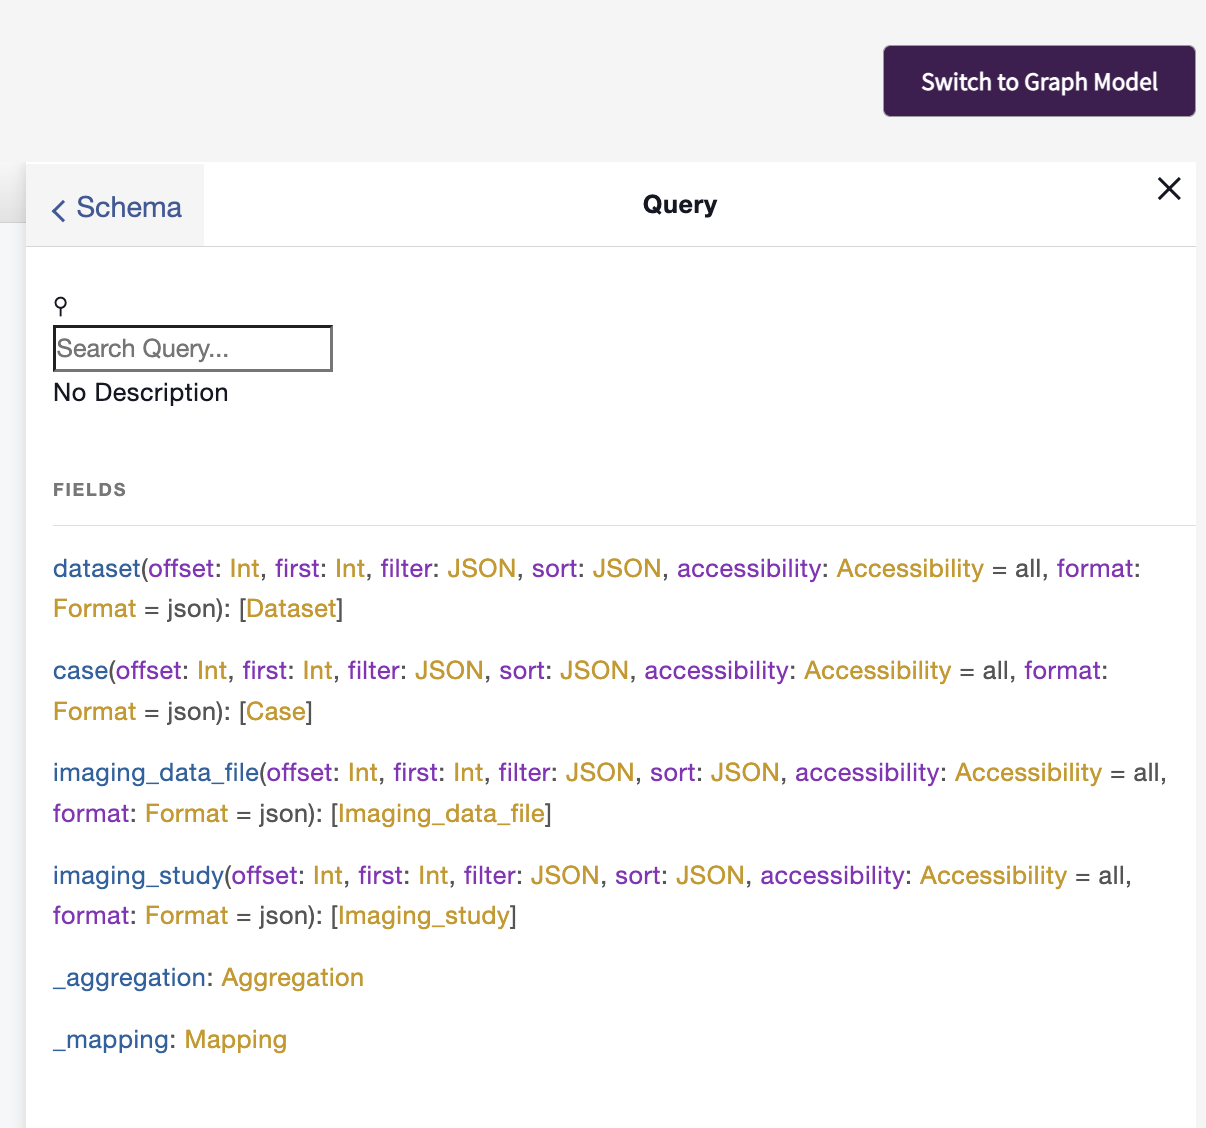

In [196]:
## an example guppy query, which hits the ElasticSearch database

## define some parameters
pid = 'Open-R1'
node = 'imaging_study'
fields = ["study_uid",
    "study_description",
    "case_ids",
    "object_id"]
filters = {"project_id": pid,
    "covid19_positive" : "Yes",
    "body_part_examined" : "CHEST",
    "study_modality" : "DX"}

## send the guppy query with the SDK class Gen3Query
## Note the "first: 100000", which makes sure we don't just get the default first 10 records
response = query.query(
                data_type=node,
                first=100000,
                fields=fields,
                filters=filters,
                sort_object={"submitter_id": "asc"},
)

# display the returned data
if 'data' in response:
    study_data = response['data'][node]
    display(study_data)

[{'case_ids': ['419639-008913'],
  'study_uid': '1.2.826.0.1.3680043.10.474.419639.233954434199549545416819083344',
  'study_description': 'XR CHEST 1 VIEW AP',
  'object_id': ['dg.MD1R/d7b7eebb-da02-445c-998b-a4dfa41d68c2']},
 {'case_ids': ['419639-011445'],
  'study_uid': '1.2.826.0.1.3680043.10.474.419639.165257741226593093304120397175',
  'study_description': 'XR CHEST 1 VIEW AP',
  'object_id': ['dg.MD1R/36af9693-7026-4995-b234-0c0f2cfd3f72']},
 {'case_ids': ['419639-010353'],
  'study_uid': '1.2.826.0.1.3680043.10.474.419639.238890717554558220188416385332',
  'study_description': 'XR CHEST 1 VIEW AP',
  'object_id': ['dg.MD1R/a3bf32c6-2367-4353-8e78-8f61c89b60b6']},
 {'case_ids': ['419639-008392'],
  'study_uid': '1.2.826.0.1.3680043.10.474.419639.146322355844825400343463634521',
  'study_description': 'XR CHEST 1 VIEW AP',
  'object_id': ['dg.MD1R/ef6aa49b-5d0b-40c5-9c41-223f33763ec8']},
 {'case_ids': ['419639-010353'],
  'study_uid': '1.2.826.0.1.3680043.10.474.419639.250028057

In [197]:
## another example guppy query, which hits the ElasticSearch database

## define some parameters
node = 'case'

fields = ["project_id",
    "submitter_id",
    "object_id"]

filters = {"sex":"Female",
    "race" : "Asian",
    "ethnicity" : "Hispanic or Latino"}

## send the guppy query with the SDK class Gen3Query
## Note the "first: 100000", which makes sure we don't just get the default first 10 records
response = query.query(
                data_type=node,
                first=100000,
                fields=fields,
                filters=filters,
                sort_object={"submitter_id": "asc"},
)

# display the returned data
if 'data' in response:
    case_data = response['data'][node]
    display(case_data)

[{'project_id': 'Open-A1',
  'submitter_id': '10000364-1599931',
  'object_id': ['dg.MD1R/b5cebe0d-907a-4ab2-aef7-b96cebd7d448']},
 {'project_id': 'Open-A1',
  'submitter_id': '10008204-ONymhwnpKUy5dlM6b4a5Ng',
  'object_id': ['dg.MD1R/1355977e-81ed-4ac5-934d-b20407eab280',
   'dg.MD1R/ed0954b6-f76d-4e74-bb7e-3818d69d8001',
   'dg.MD1R/109daa01-5969-4c2c-bb44-25efe88856e6',
   'dg.MD1R/6f330232-cee6-4fef-8d11-e5d04a5951f0',
   'dg.MD1R/c32a89c9-eca8-426a-a6b3-a22b7700ecbc',
   'dg.MD1R/9e1a772a-f5b8-485d-9f30-600e1c052313',
   'dg.MD1R/8ca85564-7d98-4312-8507-64f173333da9']}]

In [198]:
## Elastic search is handy for accessing files for a cohort since object_ids associated with each study or case are joined to the table 
study_object_ids = []
for study in study_data:
    if 'object_id' in study:
        object_id_list = study['object_id']
        for object_id in object_id_list:
            study_object_ids.append(object_id)
display(study_object_ids)

['dg.MD1R/d7b7eebb-da02-445c-998b-a4dfa41d68c2',
 'dg.MD1R/36af9693-7026-4995-b234-0c0f2cfd3f72',
 'dg.MD1R/a3bf32c6-2367-4353-8e78-8f61c89b60b6',
 'dg.MD1R/ef6aa49b-5d0b-40c5-9c41-223f33763ec8',
 'dg.MD1R/99351386-a8e5-4e87-98ca-0aaa4dacbfd0',
 'dg.MD1R/97f77b10-d034-4a0e-9e2b-a5f2c73a1f03',
 'dg.MD1R/0370fc32-0d1d-4740-b200-015771c5a762',
 'dg.MD1R/dc69bcef-f185-45ac-9945-93c9945c3c8a',
 'dg.MD1R/9047b454-f0df-44d6-a2b9-4b67ad8354fc',
 'dg.MD1R/dc53856f-cba9-4fc3-8972-b678de5ffe5b',
 'dg.MD1R/ab36a63e-bae0-4f6f-81e2-d694cd8ed81a',
 'dg.MD1R/8e23f305-c3d1-48b9-9e27-e8c9e29ef91e',
 'dg.MD1R/73061277-70ce-4bf6-8f39-f6789af33998',
 'dg.MD1R/0bd32540-b451-446e-bb44-9d69360ca5b9',
 'dg.MD1R/d37ca3d8-42e4-4dd2-94e5-288c9daea1a3',
 'dg.MD1R/a54c1a34-af22-4c3b-a30b-b67ae3ad2e3c',
 'dg.MD1R/879381ef-8697-4fa8-aa4e-6d5d3da8622e',
 'dg.MD1R/a0e6787d-d093-4d03-870b-7ce2cd26aa7f',
 'dg.MD1R/7151bb86-16c9-4baf-ab50-1bebaf663a92',
 'dg.MD1R/68ab97b3-e90b-4c3a-a83f-6e46232e3844',
 'dg.MD1R/691724b3-a

In [199]:
## Elastic search is handy for accessing files for a cohort since object_ids associated with each study or case are joined to the table 
case_object_ids = []
for case in case_data:
    if 'object_id' in case:
        object_id_list = case['object_id']
        for object_id in object_id_list:
            case_object_ids.append(object_id)
display(case_object_ids)

['dg.MD1R/b5cebe0d-907a-4ab2-aef7-b96cebd7d448',
 'dg.MD1R/1355977e-81ed-4ac5-934d-b20407eab280',
 'dg.MD1R/ed0954b6-f76d-4e74-bb7e-3818d69d8001',
 'dg.MD1R/109daa01-5969-4c2c-bb44-25efe88856e6',
 'dg.MD1R/6f330232-cee6-4fef-8d11-e5d04a5951f0',
 'dg.MD1R/c32a89c9-eca8-426a-a6b3-a22b7700ecbc',
 'dg.MD1R/9e1a772a-f5b8-485d-9f30-600e1c052313',
 'dg.MD1R/8ca85564-7d98-4312-8507-64f173333da9']

### Sending aggregations with guppy
---
* Guppy has the ability to return some useful statistics (e.g., histograms) using aggregations.
* The `Gen3Query.graphql_query()` function can be used to send aggregations and other more complex queries that the basic `Gen3Query.query()` function can't support: https://github.com/uc-cdis/gen3sdk-python/blob/8196cf4b76a65d0b9b31c8637a18dfac2a911b56/gen3/query.py#L112

In [210]:
## A more complex example using Python requests
query_txt = """{
    _aggregation {
        case {
          sex {
            histogram {
              key
              count
            }
          }
          race {
            histogram {
              key
              count
            }
          }
          ethnicity {
            histogram {
              key
              count
            }
          }
        }
    }
}"""
response = query.graphql_query(query_string=query_txt)
display(response)

{'data': {'_aggregation': {'case': {'sex': {'histogram': [{'key': 'Female',
       'count': 5931},
      {'key': 'Male', 'count': 5109},
      {'key': 'Not Reported', 'count': 2},
      {'key': 'no data', 'count': 857}]},
    'race': {'histogram': [{'key': 'White', 'count': 5112},
      {'key': 'Black or African American', 'count': 3082},
      {'key': 'Not Reported', 'count': 1814},
      {'key': 'Asian', 'count': 640},
      {'key': 'Other', 'count': 117},
      {'key': 'American Indian or Alaska Native', 'count': 41},
      {'key': 'Native Hawaiian or other Pacific Islander', 'count': 29},
      {'key': 'no data', 'count': 1064}]},
    'ethnicity': {'histogram': [{'key': 'Not Hispanic or Latino',
       'count': 10061},
      {'key': 'Hispanic or Latino', 'count': 923},
      {'key': 'Not Reported', 'count': 58},
      {'key': 'no data', 'count': 857}]}}}}}

In [212]:
## Here is an example simple script for sending a basic aggregation request that will return the data as a DataFrame ("TSV")
## https://github.com/cgmeyer/gen3sdk-python/blob/5fd6b868374f622221c0c0173a0d9489b190facd/expansion/expansion.py#L3511

data = exp.guppy_aggregation(node='case', prop='race', format='TSV')
display(data)

Requesting 'https://data.midrc.org/guppy/graphql': {'query': '{_aggregation {case {race {histogram {key count} }}}}', 'variables': None}


,key,count
0,White,5112
1,Black or African American,3082
2,Not Reported,1814
3,Asian,640
4,Other,117
5,American Indian or Alaska Native,41
6,Native Hawaiian or other Pacific Islander,29
7,no data,1064


In [190]:
## A more complex example using Python requests
query_txt = """{
    _aggregation {
        case {
          sex {
            histogram {
              key
              count
            }
          }
          race {
            histogram {
              key
              count
            }
          }
          ethnicity {
            histogram {
              key
              count
            }
          }
        }
    }
}"""
query_json = {"query": query_txt}
guppy_url = "{}/guppy/graphql".format(api)
response = requests.post(guppy_url, json=query_json, auth=auth)
display(json.loads(response.text)['data']['_aggregation']['case'])


{'sex': {'histogram': [{'key': 'Female', 'count': 5931},
   {'key': 'Male', 'count': 5109},
   {'key': 'Not Reported', 'count': 2},
   {'key': 'no data', 'count': 857}]},
 'race': {'histogram': [{'key': 'White', 'count': 5112},
   {'key': 'Black or African American', 'count': 3082},
   {'key': 'Not Reported', 'count': 1814},
   {'key': 'Asian', 'count': 640},
   {'key': 'Other', 'count': 117},
   {'key': 'American Indian or Alaska Native', 'count': 41},
   {'key': 'Native Hawaiian or other Pacific Islander', 'count': 29},
   {'key': 'no data', 'count': 1064}]},
 'ethnicity': {'histogram': [{'key': 'Not Hispanic or Latino', 'count': 10061},
   {'key': 'Hispanic or Latino', 'count': 923},
   {'key': 'Not Reported', 'count': 58},
   {'key': 'no data', 'count': 857}]}}

In [214]:
## Count the number of files in each project
files_by_project = """
{
  _aggregation {
    imaging_data_file {
      project_id {
        histogram {
          key
          count
        }
      }
    }
  }
}"""
response = query.graphql_query(files_by_project)
display(response)



{'data': {'_aggregation': {'imaging_data_file': {'project_id': {'histogram': [{'key': 'Open-A1',
       'count': 59611},
      {'key': 'Open-R1', 'count': 25003},
      {'key': 'Open-A1_PETAL_REDCORAL', 'count': 6037}]}}}}}

### Use the guppy download endpoint to access ElasticSearch tables.
---
* Tables of data from ES can be exported from the data exploration app (https://data.midrc.org/explore) by using the "Download Table" button.
* To get these sorts of tables using the API, you can use the guppy download function: https://github.com/uc-cdis/gen3sdk-python/blob/8196cf4b76a65d0b9b31c8637a18dfac2a911b56/gen3/query.py#L146

In [232]:
## This query gets all the imaging studies of modality "CT"

query.raw_data_download(
                    data_type="imaging_study",
                    fields=[
                        "study_uid",
                        "project_id",
                        "study_description",
                        "body_part_examined",
                        "case_ids",
                        "object_id"
                    ],
                    filter_object={"=": {"study_modality": "CT"}}
                )

[{'case_ids': ['10003752-DDqm9M6Q0OeSyzuCJPMw'],
  'study_uid': '2.16.840.1.114274.1818.51777461259609084757651911267630769342',
  'project_id': 'Open-A1',
  'study_description': '"CT ANGIO CHEST W"',
  'object_id': ['dg.MD1R/556fd113-1d96-489f-a717-6cead2b584bb',
   'dg.MD1R/3bb14f1d-aa48-4e4b-a05a-010393240399',
   'dg.MD1R/3a80ee80-e9be-452d-88d6-7bec53d01d0b',
   'dg.MD1R/91bc7178-4575-4339-af46-82e13baf2949',
   'dg.MD1R/1863fdd5-fdcd-4a48-af18-0770a7773164',
   'dg.MD1R/e1634f84-efd3-4bab-9f16-094ff491d32f',
   'dg.MD1R/bc8cbf19-cbb3-43bb-8594-ff184c0a65fb',
   'dg.MD1R/3a8a86b6-b228-432a-8739-a450f70c942d',
   'dg.MD1R/1ee74d88-b0e2-4906-ac53-f86a63baea44',
   'dg.MD1R/f6ceb0c3-e415-495c-a086-42d418005441']},
 {'case_ids': ['419639-010098'],
  'study_uid': '1.2.826.0.1.3680043.10.474.419639.804433314179349312091576769322',
  'project_id': 'Open-R1',
  'study_description': 'CT CHEST PULMONARY EMBOLISM (CTPE)',
  'object_id': ['dg.MD1R/b3e7f7f9-7823-4a06-9963-a74345e00081',
   'dg

In [227]:
## Here is an example getting all the cases in a particular project between ages of 45 and 47

query.raw_data_download(
                    data_type="case",
                    fields=[
                        "submitter_id",
                        "project_id",
                        "race",
                        "sex",
                        "ethnicity",
                        "age_at_index",
                        "object_id"
                    ],
                    filter_object={"AND": [{">=": {"age_at_index": 45}},
                                           {"<=": {"age_at_index": 47}},
                                           {"=": {"project_id": "Open-A1"}}]},
                    sort_fields=[{"submitter_id": "asc"}],
                    accessibility="accessible"
                )



[{'ethnicity': 'Not Hispanic or Latino',
  'race': 'White',
  'project_id': 'Open-A1',
  'sex': 'Male',
  'age_at_index': 47,
  'submitter_id': '10000364-206421',
  'object_id': ['dg.MD1R/f99825c3-68ea-4a2a-a466-9052fbe6d80a',
   'dg.MD1R/44348bdb-a831-44ec-907c-1f7002bbeff9',
   'dg.MD1R/cd02ad3c-208e-47d3-8c49-132e64939458',
   'dg.MD1R/ad7ca02e-44fc-48ba-92da-e9d2ba12941a',
   'dg.MD1R/6de50ee5-f71f-4400-98ea-416fb8e909b8',
   'dg.MD1R/72725cc9-4d7d-41c9-a052-c00385cdcc22',
   'dg.MD1R/a2c28f50-a4e1-4d19-9fe1-915060baacd0',
   'dg.MD1R/2a36fa46-c03f-4580-84af-c43d2a5ae9a6',
   'dg.MD1R/98b37604-d2b7-486b-a49b-4e3864f199b6',
   'dg.MD1R/8522ea81-9b14-4877-b455-66a63c9f43b3',
   'dg.MD1R/fd6dd641-f65c-473c-bdd7-518afa0dae11',
   'dg.MD1R/402505b9-dd29-430f-aa3e-afe1d3115d40',
   'dg.MD1R/15a058a6-8331-4493-9fdb-76517392f1e9',
   'dg.MD1R/d4d46fcd-0d3c-4e2c-b35c-13627c99b4f9',
   'dg.MD1R/07d10b9e-5bcd-4b03-86da-75cef411a230',
   'dg.MD1R/6139aa55-923b-4318-9d4d-a1e2ce0b7a7c',
   'dg.M